In [1]:
# -*- coding: utf-8 -*-
# pylint: disable=invalid-name

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from spectral import *
import numpy as np
import scipy.spatial.distance as distance
import pylab
import spectral.io.envi as envi
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from timeit import default_timer as timer

In [6]:
from autoclustering import find_maxdist_clusters
from hiersubclustering import subdivide_by_modules
from visual_utils import show_classes, show_histogram, show_centers
from math_utils import cluster_histogram, normalized

Читаем изображение.

In [7]:
#img = open_image('92AV3C.lan')
# gt = open_image('92AV3GT.GIS').read_band(0)
img = envi.open('f080611t01p00r07rdn_c_sc01_ort_img.hdr')

In [8]:
print(img)

	Data Source:   '/home/marko/HSI/f080611t01p00r07rdn_c/f080611t01p00r07rdn_c_sc01_ort_img'
	# Rows:           1924
	# Samples:         753
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16


In [9]:
data = img[:,:,:]
#data = img[400:1000, 200:, :]
#data = img[400:700, 200:400, :]

In [10]:
data[data <= 0] = 1
print(data.dtype)

>i2


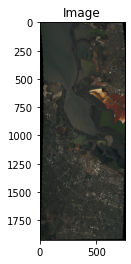

In [11]:
view = imshow(data, (29, 20, 12), title="Image")

Проверим работу функции удаления континуума написанных на С.

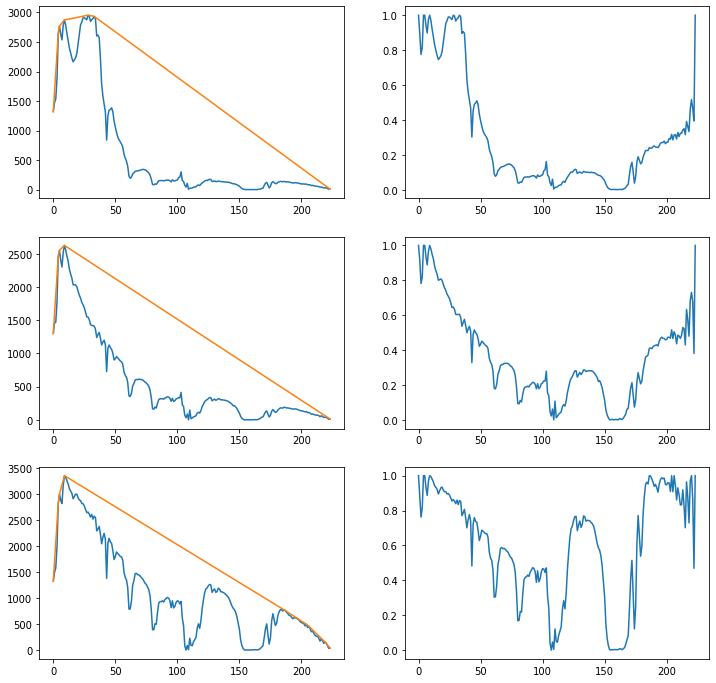

In [11]:
from continuum import continuum, continuum_removed
inarr = np.array([data[561, 501].astype(float), data[599, 300].astype(float), data[41, 525].astype(float)])
outarr = np.empty_like(inarr)
outarr_rem = np.empty_like(inarr)
continuum(inarr, outarr)
continuum_removed(inarr, outarr_rem)

fig = pylab.figure()
fig.set_size_inches(3*4, 2*6)

for i in range(3):
    pylab.subplot(3, 2, (i*2)+1)
    pylab.plot(inarr[i])
    pylab.plot(outarr[i])
    pylab.subplot(3, 2, (i*2)+2)
    pylab.plot(outarr_rem[i])

pylab.show()


Проверим работу функции удаления континуума на питоне.

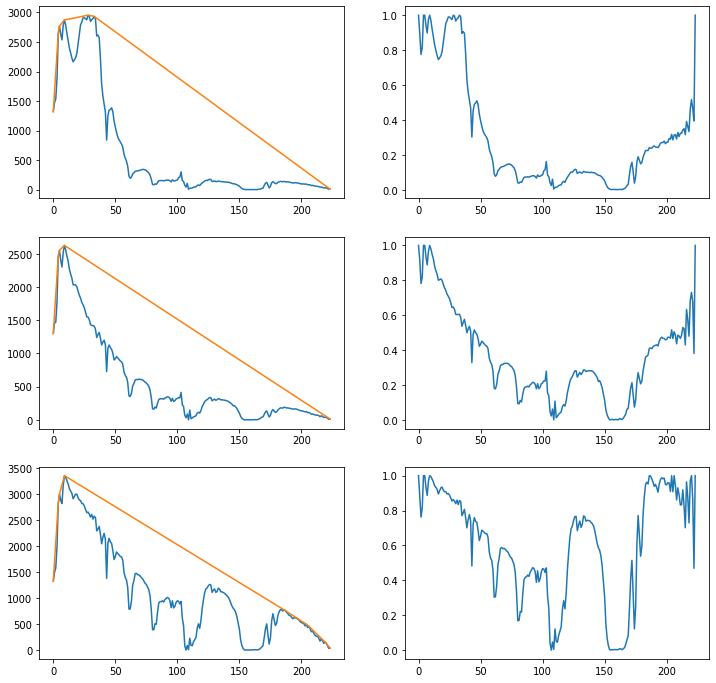

In [12]:
from pycontinuum import pycontinuum, pycontinuum_removed
inarr = np.array([data[561, 501].astype(float), data[599, 300].astype(float), data[41, 525].astype(float)])
outarr = np.empty_like(inarr)
outarr_rem = np.empty_like(inarr)

for i in range(0, inarr.shape[0]):
    pycontinuum(inarr[i], outarr[i])
    pycontinuum_removed(inarr[i], outarr[i], outarr_rem[i])

fig = pylab.figure()
fig.set_size_inches(3*4, 2*6)

for i in range(3):
    pylab.subplot(3, 2, (i*2)+1)
    pylab.plot(inarr[i])
    pylab.plot(outarr[i])
    pylab.subplot(3, 2, (i*2)+2)
    pylab.plot(outarr_rem[i])

pylab.show()

In [13]:
from utils import filter_out_invalid_signatures
sigs = filter_out_invalid_signatures(data)

In [14]:
avg = np.average(sigs, axis=0)
cr_avg = pycontinuum_removed(avg, pycontinuum(avg))

In [15]:
maxes = np.max(sigs, axis=0)
cr_maxes = pycontinuum_removed(maxes, pycontinuum(maxes))

In [16]:
from math_utils import find_max_diff_l2
max_diff_l2 = find_max_diff_l2(sigs, avg)
cr_max_diff_l2 = pycontinuum_removed(max_diff_l2, pycontinuum(max_diff_l2))

In [17]:
from math_utils import find_max_diff_l1
max_diff_l1 = find_max_diff_l1(sigs, avg)
cr_max_diff_l1 = pycontinuum_removed(max_diff_l1, pycontinuum(max_diff_l1))

In [18]:
from math_utils import find_max_diff_angle
max_diff_angle = find_max_diff_angle(sigs, avg)
cr_max_diff_angle = pycontinuum_removed(max_diff_angle, pycontinuum(max_diff_angle))

In [19]:
from math_utils import find_with_max_norm2
max_norm2 = find_with_max_norm2(sigs)
cr_max_norm2 = pycontinuum_removed(max_norm2, pycontinuum(max_norm2))

In [20]:
from math_utils import find_with_max_norm1
max_norm1 = find_with_max_norm1(sigs)
cr_max_norm1 = pycontinuum_removed(max_norm1, pycontinuum(max_norm1))

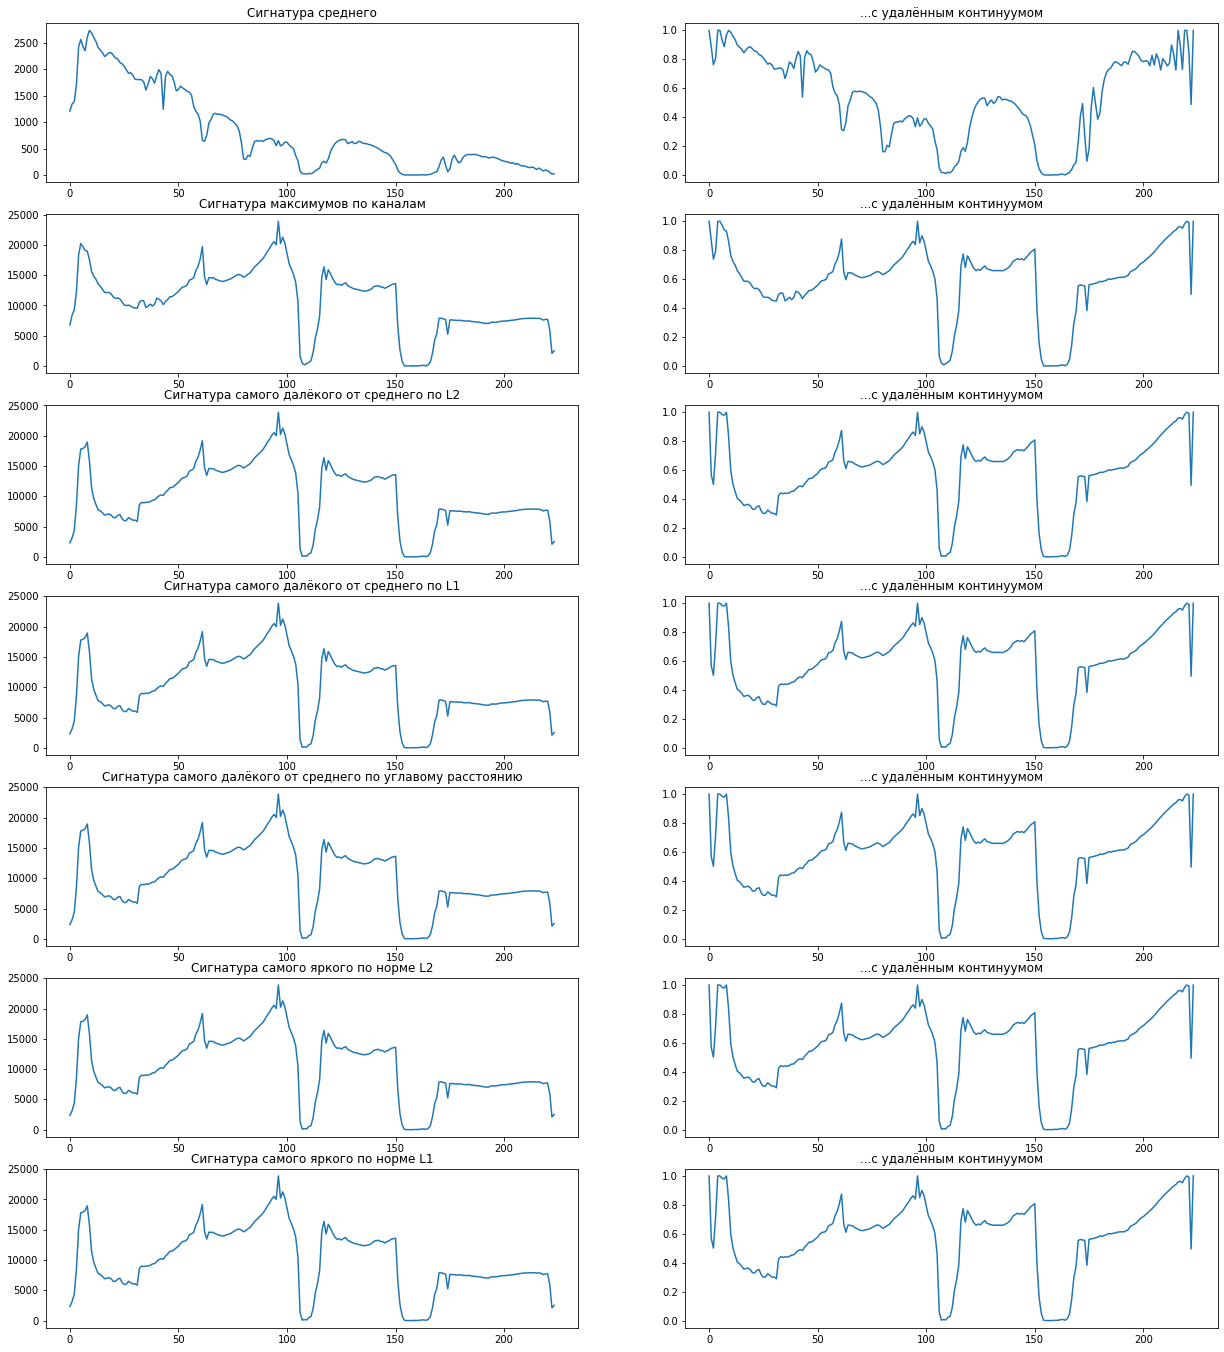

In [21]:
figs = [
    {
     'title': 'Сигнатура среднего',
     'sig': avg,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_avg
    },
    {
     'title': 'Сигнатура максимумов по каналам',
     'sig': maxes,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_maxes
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L2',
     'sig': max_diff_l2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l2
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L1',
     'sig': max_diff_l1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l1
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по углавому расстоянию',
     'sig': max_diff_angle,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_angle
    },
    {
     'title': 'Сигнатура самого яркого по норме L2',
     'sig': max_norm2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm2
    },
    {
     'title': 'Сигнатура самого яркого по норме L1',
     'sig': max_norm1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm1
    }
]


fig = pylab.figure()
fig.set_size_inches(len(figs)*3, 2*12)

for i in range(len(figs)):
    ax = pylab.subplot(len(figs), 2, (i*2)+1)
    ax.set_title(figs[i]['title'])
    pylab.plot(figs[i]['sig'])
    ax = pylab.subplot(len(figs), 2, (i*2)+2)
    ax.set_title(figs[i]['cr-title'])
    pylab.plot(figs[i]['cr-sig'])

pylab.show()

Посмотрим где находится самая отличающаяся сигнатура.

In [22]:
from utils import find_image_coords_of_signature
coords = find_image_coords_of_signature(data, max_diff_l2)
print(coords)

(1315, 98)


Посмотрим как будет выглядет если удалят континуум на основе (Б-сплайна) максимумов.

[(0, 6788.0), (4, 18356.0), (5, 20226.0), (96, 23885.0), (220, 7708.0), (223, 2521.0)]


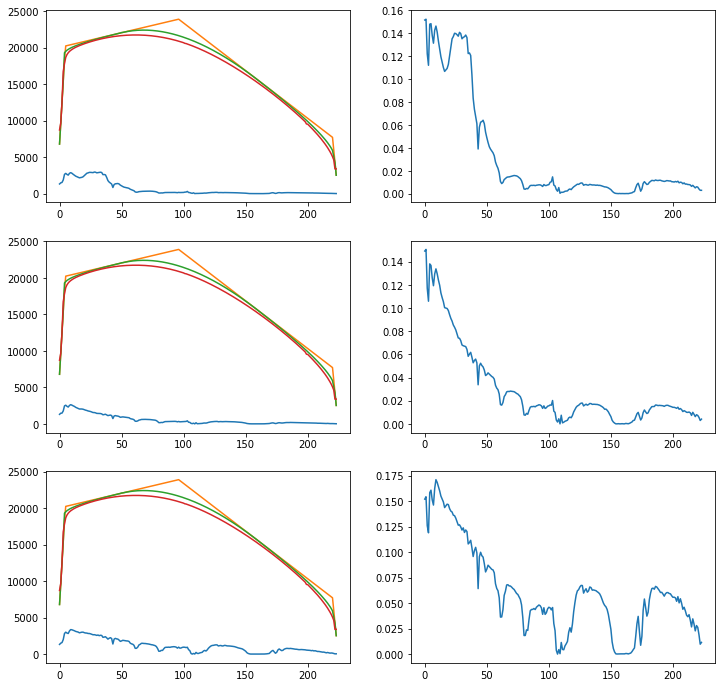

In [109]:
from pycontinuum import pycontinuum, pycontinuum_removed, pycontinuum_points
from math_utils import bspline3_from_points, bspline2_from_points
inarr = np.array([data[561, 501].astype(float), data[599, 300].astype(float), data[41, 525].astype(float)])
outarr_rem = np.empty_like(inarr)

cont = pycontinuum(maxes)
cont_points = pycontinuum_points(maxes)
print(cont_points)
cont_bspline3 = bspline3_from_points(cont_points)
cont_bspline2 = bspline2_from_points(cont_points)

for i in range(0, inarr.shape[0]):
    pycontinuum_removed(inarr[i], cont_bspline3, outarr_rem[i])

fig = pylab.figure()
fig.set_size_inches(3*4, 2*6)

for i in range(3):
    pylab.subplot(3, 2, (i*2)+1)
    pylab.plot(inarr[i])
    pylab.plot(cont)
    pylab.plot(cont_bspline2)
    pylab.plot(cont_bspline3)
    pylab.subplot(3, 2, (i*2)+2)
    pylab.plot(outarr_rem[i])

pylab.show()

Проверим работу функции вычисления частичного континуума на питоне.

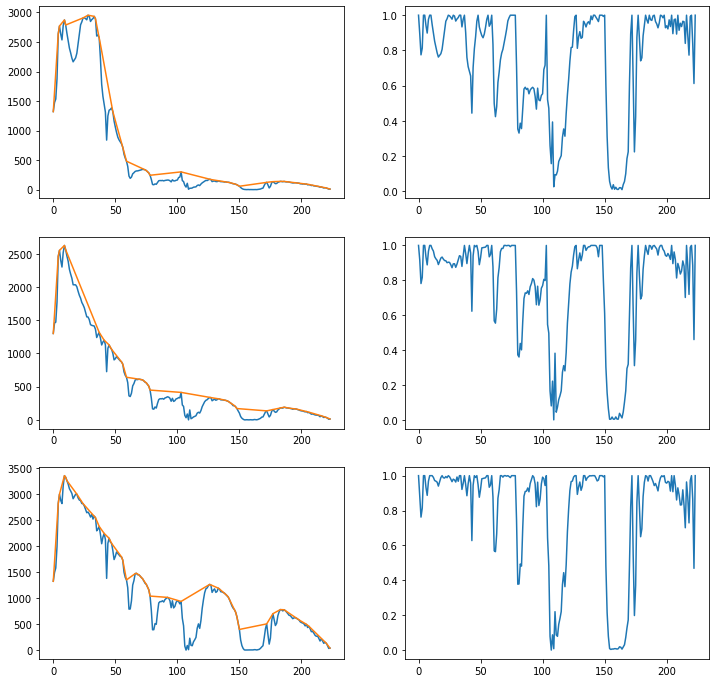

In [120]:
from pycontinuum import pypartial_continuum, pycontinuum_removed
inarr = np.array([data[561, 501].astype(float), data[599, 300].astype(float), data[41, 525].astype(float)])
outarr = np.empty_like(inarr)
outarr_rem = np.empty_like(inarr)

for i in range(0, inarr.shape[0]):
    pypartial_continuum(inarr[i], 3, outarr[i])
    pycontinuum_removed(inarr[i], outarr[i], outarr_rem[i])

fig = pylab.figure()
fig.set_size_inches(3*4, 2*6)

for i in range(3):
    pylab.subplot(3, 2, (i*2)+1)
    pylab.plot(inarr[i])
    pylab.plot(outarr[i])
    pylab.subplot(3, 2, (i*2)+2)
    pylab.plot(outarr_rem[i])

pylab.show()

Также Б-сплайны с частичными континуумами.

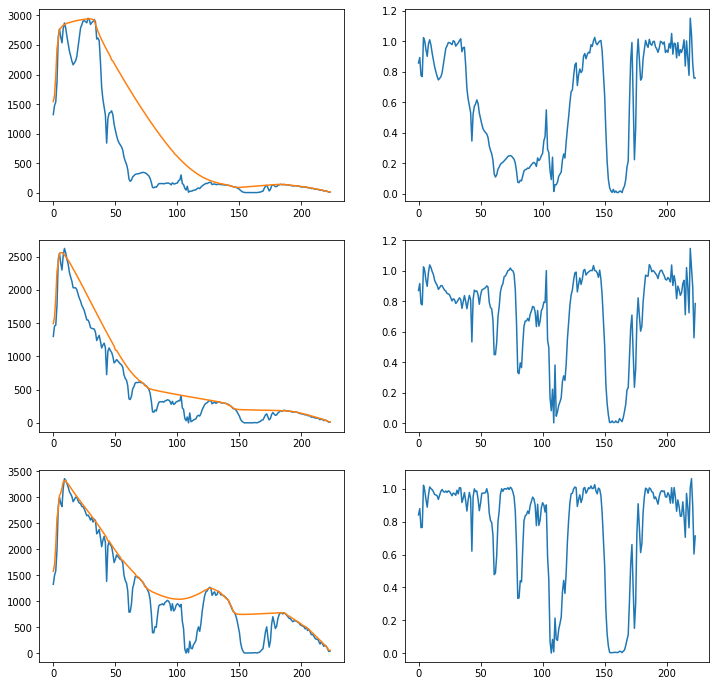

In [122]:
from pycontinuum import pypartial_continuum, pycontinuum_removed, pypartial_continuum_points
from math_utils import bspline3_from_points, bspline2_from_points
inarr = np.array([data[561, 501].astype(float), data[599, 300].astype(float), data[41, 525].astype(float)])
outarr = np.empty_like(inarr)
outarr_rem = np.empty_like(inarr)

step = 8

cont_bspline2s = []
cont_bspline3s = []

for i in range(0, inarr.shape[0]):
    pypartial_continuum(inarr[i], step, outarr[i])
    cont_bspline2s.append(bspline2_from_points(pypartial_continuum_points(inarr[i], step)))
    cont_bspline3s.append(bspline3_from_points(pypartial_continuum_points(inarr[i], step)))
    pycontinuum_removed(inarr[i], cont_bspline3s[i], outarr_rem[i])

fig = pylab.figure()
fig.set_size_inches(3*4, 2*6)

for i in range(3):
    pylab.subplot(3, 2, (i*2)+1)
    pylab.plot(inarr[i])
    #pylab.plot(outarr[i])
    #pylab.plot(cont_bspline2s[i])
    pylab.plot(cont_bspline3s[i])
    pylab.subplot(3, 2, (i*2)+2)
    pylab.plot(outarr_rem[i])

pylab.show()

Поверяем работу алгоритма кластеризации и иерархической подкластеризации.

In [ ]:
(class_map, centers) = find_maxdist_clusters(data, 0.8)
print('Centers\' shape: ', centers.shape)

In [ ]:
subclass_map = subdivide_by_modules(data, class_map, centers.shape[0], True)

In [ ]:
view = show_classes(subclass_map - 1)

In [ ]:
counts_per_clusters = cluster_histogram(centers, class_map)

In [ ]:
show_histogram(counts_per_clusters, 'Number of signatures per cluster')

In [ ]:
show_centers(centers, 'Final centers')